# Notebook implementing the stable tree algorithm in Bertsimas et al. (https://arxiv.org/abs/2305.17299)

In [1]:
import sys
import itertools
from pathlib import Path
src_path = Path("../src/dt-distance").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from dt_distance.data_processor import DataProcessor
from dt_distance.tree_parser import TreeParser
from dt_distance.distance_calculator import DistanceCalculator
from dt_distance.problem_params import ProblemParams
import matplotlib.pyplot as plt
# set seed for reproducibility
np.random.seed(42)

Parameters listed in the paper:

In [2]:
DEPTHS = list(range(3, 13))
MIN_SAMPLES = [3, 5, 10, 30, 50]

## Loading the breast cancer dataset

In [3]:
data_breast_cancer = load_breast_cancer(as_frame=True)
X_full = data_breast_cancer["data"]
y_full = data_breast_cancer["target"]
print("X_full shape: ", X_full.shape)
X_full.head()

X_full shape:  (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
print("y_full shape: ", y_full.shape)
y_full.head()

y_full shape:  (569,)


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

print("X_train shape: {}, X_test shape: {}".format(X_train.shape, X_test.shape))
print("y_train shape: {}, y_test shape: {}".format(y_train.shape, y_test.shape))

X_train shape: (455, 30), X_test shape: (114, 30)
y_train shape: (455,), y_test shape: (114,)


## Step 1: Split Training set into X0 and X1

In [6]:
def random_train_split(X,y):
    N = X.shape[0]
    indices = np.random.permutation(N)
    X0, y0 = X[indices[:N // 2]], y[indices[:N // 2]]
    return X0, y0

X0, y0 = random_train_split(X_train.values, y_train.values)
X0.shape, y0.shape

((227, 30), (227,))

## Step 3: Bootstrap and Train ($T_{0}$) Tree Set

In [7]:
def train_decision_tree(X, y, depth, min_samples_leaf):
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf)
    clf.fit(X, y)
    return clf

def bootstrap_trees(X, y, depths, min_samples, B):
    '''
    Create B bootstrap trees by sampling with replacement from X_0
    '''
    trees = []
    for _ in range(B):
        X_sample, y_sample = resample(X, y, replace= True)
        depth = np.random.choice(depths)
        min_leaf = np.random.choice(min_samples)
        tree = train_decision_tree(X_sample, y_sample, depth, min_leaf)
        trees.append(tree)
    return trees

T0 = bootstrap_trees(X0, y0, DEPTHS, MIN_SAMPLES, 100)
print("Number of trees in T0:", len(T0))

Number of trees in T0: 100


## Step 4: Train Second Tree Collection: $\mathcal{T}$

Train the second tree collection $\mathcal{T}$ using the same method but on the entire training set.

In [8]:
T = bootstrap_trees(X_train.values, y_train.values, DEPTHS, MIN_SAMPLES, 100)
print("Number of trees in T:", len(T))

Number of trees in T: 100


## Step 5.1: Compute Mean distance for each $T \in T$

- For each tree in $\mathcal{T}$, compute `dt-distance` for all $T \in T_{0}$ and average over all B
- Compute AUC score from Test Data to get out-of-sample predictive power
- Return $B$ average distances 
- Intuition for larger set: Say we get new data in the future-> how much do these new trees (entire set)$\mathcal{T}$ deviate from the previosuly smaller set of trees $T_{0}$?
- Only structural differences (via path definitions) matter for problem params, so the path_converstion does not care about the dataset, but the bounds on features, quantification of categories, and assigned class labels as a sequence of splits

In [9]:
def compute_average_distances(T0, T, X_train, y_train):
    X_train_values = X_train.values if hasattr(X_train, 'values') else X_train
    
    distances = []
    for i, tree_b in enumerate(T):
        d_b = 0.0
        for tree_beta in T0:
            distance_calculator = DistanceCalculator(tree_beta, tree_b, X=X_train_values, y=y_train)
            d_b += distance_calculator.compute_tree_distance()
        d_b /= len(T0)
        distances.append(d_b)
    
    return distances
distances = compute_average_distances(T0, T, X_train, y_train)
print("Number of distances computed:", len(distances))

Number of distances computed: 100


## Step 5.2: Compute out-of-sample Predicitive Performance

Calculate the AUC score for each tree in $\mathcal{T}$ using the test set.

In [10]:
def evaluate_predictive_power(trees, X_holdout, y_holdout):
    auc_scores = []
    for tree in trees:
        y_proba = tree.predict_proba(X_holdout)[:, 1]
        auc = roc_auc_score(y_holdout, y_proba)
        auc_scores.append(auc)
    return auc_scores

auc_scores = evaluate_predictive_power(T, X_test.values, y_test.values)
print("Average AUC score:", np.mean(auc_scores))

Average AUC score: 0.9595316082541763


## Step 6: Find the Pareto Optimal Set $\mathcal{T}^{*}$ from $\mathcal{T}$

- Multi-objective function to find pareto optimal tree set from $\mathcal{T}$ based on average distance, $d_{b}$ , $\forall b \in \mathcal{T}$ and the out-of-sample AUC_ROC score $a_{b}$, $\forall b \in \mathcal{T}$
- **Pareto Optimal Definition:** $(d_{b'} \leq d_b \text{ and } \alpha_{b'} > \alpha_b) \text{ or } (d_{b'} < d_b \text{ and } \alpha_{b'} \geq \alpha_b)$

In [11]:
def pareto_optimal_trees(distances, auc_scores):
    pareto_trees = []
    for i, (d_i, a_i) in enumerate(zip(distances, auc_scores)):
        dominated = False
        for j, (d_j, a_j) in enumerate(zip(distances, auc_scores)):
            if i != j and ((d_j <= d_i and a_j > a_i) or (d_j < d_i and a_j >= a_i)):
                dominated = True
                break
        if not dominated:
            pareto_trees.append(i)
    return pareto_trees

pareto_trees = pareto_optimal_trees(distances, auc_scores)
print("Number of Pareto optimal trees:", len(pareto_trees))

Number of Pareto optimal trees: 7


## Step 7: Find the Optimal Tree from the Pareto Optimal Set, $\mathcal{T^{*}}$

-  $\mathbb{T}^\star = \underset{\mathbb{T}_b \in \mathcal{T}^\star}{\text{argmax}} \ f(d_b, \alpha_b)$
- Need to consider here what we value: stability or predicitve power.
- Current function is most stable model among all “good enough” performers.
- Can modify to find optimal trade-off for accuracy-stability
- Indicator function where:
    - 1 if $\alpha_{b}$ is within ε of the best score
    - 0 otherwise

In [12]:
def select_final_tree(distances, auc_scores, pareto_indices, epsilon=0.01):
    best_auc = max(auc_scores)
    candidates = [i for i in pareto_indices if auc_scores[i] >= (1 - epsilon) * best_auc]
    if not candidates:
        candidates = pareto_indices
    best_idx = max(candidates, key=lambda i: auc_scores[i] - distances[i])
    return best_idx

selected_tree_index = select_final_tree(distances, auc_scores, pareto_trees)
print("Selected tree index:", selected_tree_index)

Selected tree index: 47


### Plot the Pareto optimal tree:

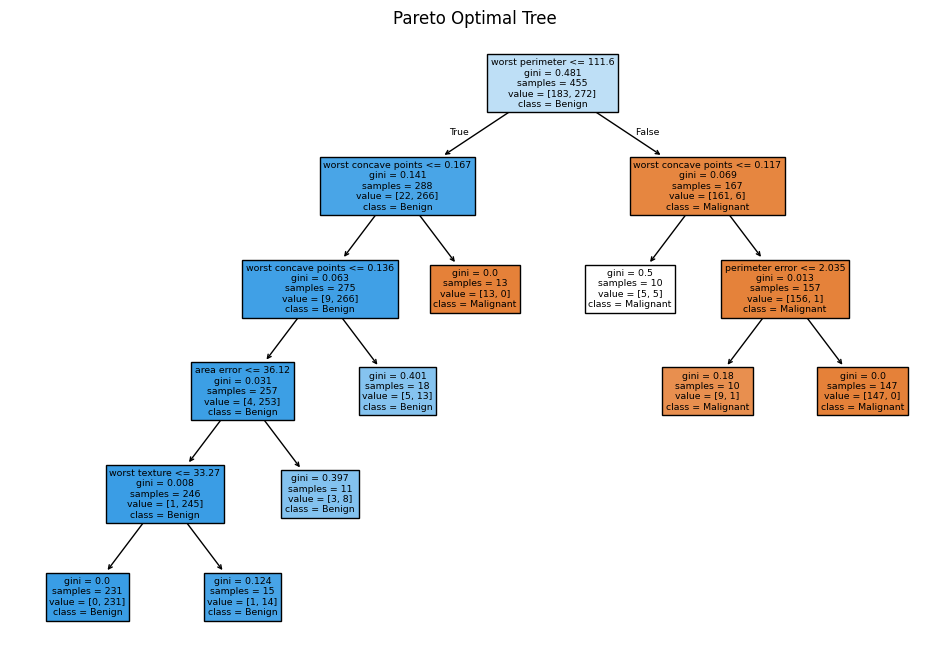

In [13]:
selected_tree = T[selected_tree_index]
plt.figure(figsize=(12, 8))
plot_tree(selected_tree, 
          feature_names=X_full.columns,
          class_names=["Malignant", "Benign"],
          filled=True)
plt.title("Pareto Optimal Tree")
plt.show()

### Pareto Frontier Visualization

- Plotting pareto frontier from a collection of trees based on average distance, $d_{b}$ , $\forall b \in \mathcal{T}$ and the out-of-sample AUC_ROC score $a_{b}$, $\forall b \in \mathcal{T}$

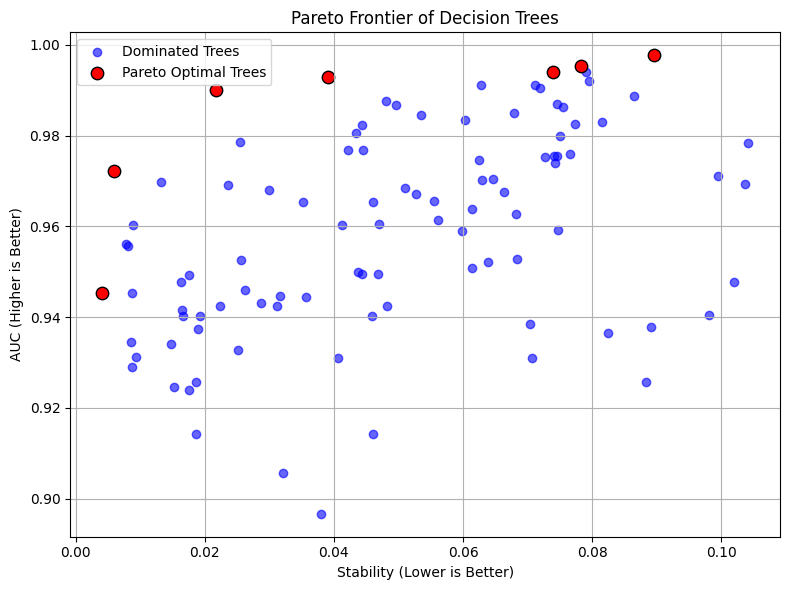

In [14]:
def plot_pareto_frontier(distances, auc_scores, pareto_indices):
    distances = np.array(distances)
    auc_scores = np.array(auc_scores)
    pareto_indices = set(pareto_indices)
    is_pareto = np.array([i in pareto_indices for i in range(len(distances))])
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(distances[~is_pareto], auc_scores[~is_pareto], c='blue', label='Dominated Trees', alpha=0.6)
    plt.scatter(distances[is_pareto], auc_scores[is_pareto], c='red', edgecolors='black', s=80, label='Pareto Optimal Trees')
    plt.xlabel("Stability (Lower is Better)")
    plt.ylabel("AUC (Higher is Better)")
    plt.title("Pareto Frontier of Decision Trees")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pareto_frontier(distances, auc_scores, pareto_trees)

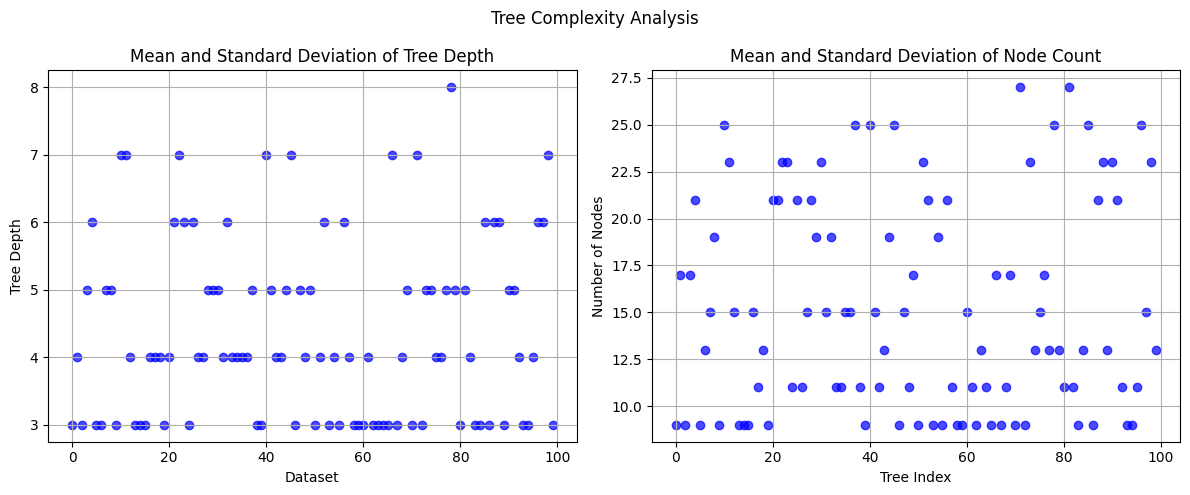

In [15]:
def plot_tree_complexity_metrics(trees):

    depths = [tree.get_depth() for tree in trees]
    node_counts = [tree.tree_.node_count for tree in trees]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Tree Depth Plot
    axs[0].scatter(range(len(trees)), depths, color='blue', alpha=0.7)
    axs[0].set_title("Mean and Standard Deviation of Tree Depth")
    axs[0].set_xlabel("Dataset")
    axs[0].set_ylabel("Tree Depth")
    axs[0].grid(True)

    # Node Count Plot
    axs[1].scatter(range(len(trees)), node_counts, color='blue', alpha=0.7)
    axs[1].set_title("Mean and Standard Deviation of Node Count")
    axs[1].set_xlabel("Tree Index")
    axs[1].set_ylabel("Number of Nodes")
    axs[1].grid(True)

    plt.suptitle("Tree Complexity Analysis")
    plt.tight_layout()
    plt.show()
plot_tree_complexity_metrics(T)